In phase 1 of the [Ag1000G project](http://www.malariagen.net/ag1000g) we have whole genome sequence data for mosquitoes from 9 African countries. As part of our analysis of population structure, I recently needed to calculate average F<sub>ST</sub> between each pair of populations. I also needed to calculate F<sub>ST</sub> in windows over the genome, to look for genome regions that are particularly differentiated between certain populations.

F<sub>ST</sub> is a statistic which seems simple at first yet quickly becomes very technical when you start reading the literature. I asked around my lab for advice and [George](http://www.well.ox.ac.uk/george-busby) pointed me to [Bhatia et al. (2013)](http://www.pubmedcentral.nih.gov/articlerender.fcgi?artid=3759727&tool=pmcentrez&rendertype=abstract) which provides some clear advice on how to estimate F<sub>ST</sub>. However, Bhatia et al. were working with relatively well-studied human populations, and mosquito population genetics can get pretty extreme by comparison, so I didn't want to take anything for granted.

To help explore the impact of different F<sub>ST</sub> estimators and SNP ascertainment schemes, I implemented both the Weir and Cockerham estimator and the Hudson estimator in  [`scikit-allel`](http://scikit-allel.readthedocs.org/en/latest/stats/fst.html). This post gives some examples of using these functions with large scale SNP data, and some practical experiences from applying them to mosquito populations.

## Setup

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import bcolz
import pandas
import allel; print('scikit-allel', allel.__version__)

scikit-allel 1.0.0b3


I have a copy of the [Ag1000G phase 1 AR3 data release](http://www.malariagen.net/data/ag1000g-phase1-ar3) on a local drive. The SNP genotype data is available in an HDF5 file.

In [2]:
callset_fn = 'data/2015-09-21/ag1000g.phase1.ar3.pass.h5'
callset = h5py.File(callset_fn, mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.pass.h5" (mode r)>

Let's work with chromosome arm 3L.

In [3]:
chrom = '3L'
# load all variant positions
pos_all = allel.SortedIndex(callset[chrom]['variants']['POS'])
pos_all

0,1,2,3,4,...,9643188,9643189,9643190,9643191,9643192
9790,9798,9812,9818,9829,...,41956532,41956537,41956541,41956551,41956556


There are 9,643,193 SNPs on this chromosome, genotyped in 765 individuals, so this is a relatively big dataset, too big to work with in memory uncompressed. With version 0.19.0 of scikit-allel or later we can run computations directly against the data on disk, and so avoid loading data into memory.

In [4]:
genotype_all = allel.GenotypeChunkedArray(callset[chrom]['calldata']['genotype'])
genotype_all

<GenotypeChunkedArray shape=(9643193, 765, 2) dtype=int8 chunks=(6553, 10, 2)
   nbytes=13.7G cbytes=548.0M cratio=25.7
   compression=gzip compression_opts=3
   values=h5py._hl.dataset.Dataset>

This array would be 13.7G uncompressed, but [genotype data compress very well](http://alimanfoo.github.io/2016/09/21/genotype-compression-benchmark.html), so the actual size on disk is only 548M.

There is also a table of sample metadata which we'll need because it tells us which mosquito comes from which population.

In [5]:
df_samples = pandas.read_csv('data/2015-09-21/samples.meta.txt',
                             sep='\t', index_col='index')
df_samples.head()

,ox_code,src_code,sra_sample_accession,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,latitude,longitude
index,,,,,,,,,,,,,,,
0,AB0085-C,BF2-4,ERS223996,BFS,Burkina Faso,Pala,Austin Burt,Sam O'Loughlin,2012,S,F,89905852,28.01,11.150,-4.235
1,AB0087-C,BF3-3,ERS224013,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,116706234,36.76,11.233,-4.472
2,AB0088-C,BF3-5,ERS223991,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,112090460,23.30,11.233,-4.472
3,AB0089-C,BF3-8,ERS224031,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,145350454,41.36,11.233,-4.472
4,AB0090-C,BF3-10,ERS223936,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,105012254,34.64,11.233,-4.472


The 'index' column in this table corresponds to the order of columns in the genotype array.

Let's pick two populations to work with.

In [6]:
pop1 = 'BFM'
pop2 = 'AOM'
n_samples_pop1 = np.count_nonzero(df_samples.population == pop1)
n_samples_pop2 = np.count_nonzero(df_samples.population == pop2)
print(pop1, n_samples_pop1, pop2, n_samples_pop2)

BFM 69 AOM 60


I've chosen BFM (*Anopheles coluzzii* from Burkina Faso) and AOM (*Anopheles coluzzii* from Angola) because F<sub>ST</sub> is reasonably high between these two populations.

Now compute allele counts in each population. This takes a minute or so.

In [7]:
# dictionary mapping population names to sample indices
subpops = {
    pop1: df_samples[df_samples.population == pop1].index,
    pop2: df_samples[df_samples.population == pop2].index,
}
# allele counts
acs = genotype_all.count_alleles_subpops(subpops)
acs

<AlleleCountsChunkedTable shape=(9643193,) dtype=[('AOM', '<i4', (4,)), ('BFM', '<i4', (4,))]
   nbytes=294.3M cbytes=23.5M cratio=12.5
   values=allel.chunked.storage_zarr.ZarrTable>

Finally, we can filter out variants that aren't segregating in the union of our two populations. Let's also filter out multiallelic variants for simplicity.

In [8]:
acu = allel.AlleleCountsArray(acs[pop1][:] + acs[pop2][:])
flt = acu.is_segregating() & (acu.max_allele() == 1)
print('retaining', np.count_nonzero(flt), 'SNPs')

retaining 3177369 SNPs


In [9]:
pos = pos_all.compress(flt)
ac1 = allel.AlleleCountsArray(acs[pop1].compress(flt, axis=0)[:, :2])
ac2 = allel.AlleleCountsArray(acs[pop2].compress(flt, axis=0)[:, :2])
genotype = genotype_all.compress(flt, axis=0)
genotype

<GenotypeChunkedArray shape=(3177369, 765, 2) dtype=int8 chunks=(776, 765, 2)
   nbytes=4.5G cbytes=412.7M cratio=11.2
   compression=blosc compression_opts={'cname': 'lz4', 'shuffle': 1, 'clevel': 5}
   values=zarr.core.Array>

Note that the new `genotype` array we have created is in-memory, however we are making use of [compressed arrays](http://zarr.readthedocs.io/) to store these intermediate data, so the amount of memory required is small. Btw don't get confused with the name of the 'compress' method, this comes from [numpy](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.compress.html) and means making a selection along a particular axis, it has nothing to do with data compression which is handled automatically by `scikit-allel`.

## Comparing F<sub>ST</sub> estimators

### Per-SNP estimates

Let's first compute the per-SNP F<sub>ST</sub> value from each of the two estimators. The Weir & Cockerham estimator takes a little longer because it has to revisit the genotype data. The Hudson estimator is faster because it only needs the allele counts, which we've already computed. 

In [10]:
# sample indices for population 1
pop1_idx = subpops[pop1]
# sample indices for population 2
pop2_idx = subpops[pop2]
a, b, c = allel.stats.weir_cockerham_fst(genotype, subpops=[pop1_idx, pop2_idx], max_allele=1)
snp_fst_wc = (a / (a + b + c))[:, 0]
snp_fst_wc

array([-0.00102459,  0.01277143,  0.08574083, ..., -0.00102459,
        0.0554781 ,  0.08247673])

In [11]:
num, den = allel.stats.hudson_fst(ac1, ac2)
snp_fst_hudson = num / den
snp_fst_hudson

array([ 0.        ,  0.01459854,  0.08403361, ...,  0.        ,
        0.05042017,  0.07563025])

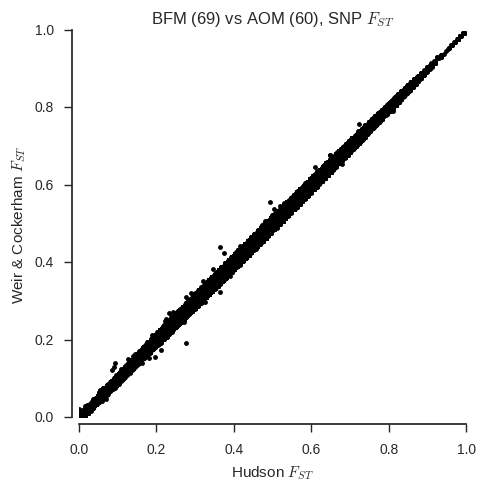

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.despine(ax=ax, offset=5)
ax.plot(snp_fst_hudson, snp_fst_wc, color='k', marker='.', linestyle=' ')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Hudson $F_{ST}$')
ax.set_ylabel('Weir & Cockerham $F_{ST}$')
ax.set_title('%s (%s) vs %s (%s), SNP $F_{ST}$' % (pop1, n_samples_pop1, pop2, n_samples_pop2));

With a couple of exceptions, the two estimators are virtually identical for all SNPs. However, one thing that Bhatia et al. warn is that the Weir & Cockerham estimator can give different results if sample sizes are unequal. We've chosen two populations with similar sample sizes, but what happens if we fake one of the populations to have a much smaller sample size?

In [13]:
# keep only 20 samples from first population
pop1_idx_ds = subpops[pop1][:20]
a, b, c = allel.stats.weir_cockerham_fst(genotype, subpops=[pop1_idx_ds, pop2_idx], max_allele=1)
# there may be some non-segregating variants after down-sampling, suppress errors about zero division
with np.errstate(divide='ignore', invalid='ignore'):
    snp_fst_wc_ds = (a / (a + b + c))[:, 0]
snp_fst_wc_ds

array([        nan,  0.03306823,  0.03605869, ...,         nan,
        0.02435467,  0.04264706])

In [14]:
np.count_nonzero(np.isnan(snp_fst_wc_ds))

1105405

In [15]:
# recompute allele counts for downsampled population
ac1_ds = genotype.count_alleles(subpop=pop1_idx_ds, max_allele=1)
num, den = allel.stats.hudson_fst(ac1_ds, ac2)
# there may be some non-segregating variants after down-sampling, suppress errors about zero division
with np.errstate(divide='ignore', invalid='ignore'):
    snp_fst_hudson_ds = num / den
snp_fst_hudson_ds

array([        nan,  0.        ,  0.08403361, ...,         nan,
        0.05042017,  0.07563025])

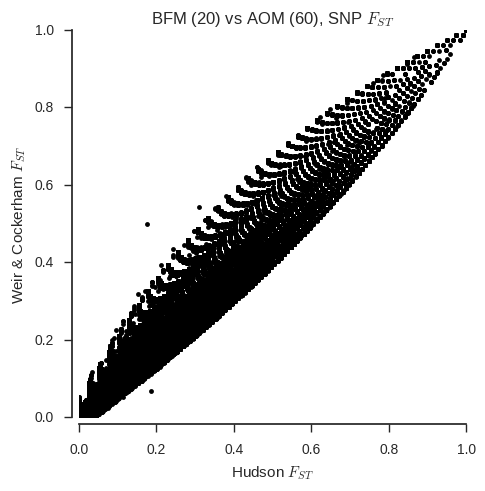

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.despine(ax=ax, offset=5)
ax.plot(snp_fst_hudson_ds, snp_fst_wc_ds, color='k', marker='.', linestyle=' ')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Hudson $F_{ST}$')
ax.set_ylabel('Weir & Cockerham $F_{ST}$')
ax.set_title('%s (20) vs %s (%s), SNP $F_{ST}$' % (pop1, pop2, n_samples_pop2));

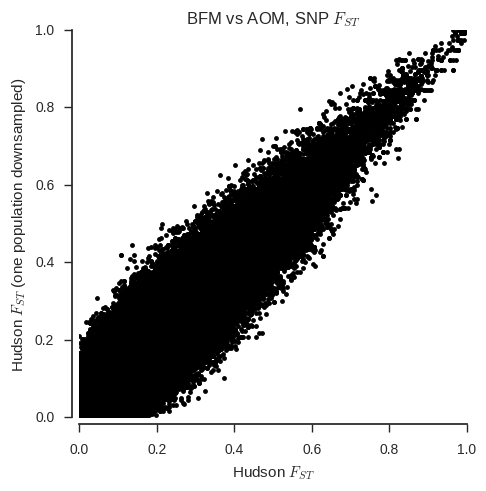

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.despine(ax=ax, offset=5)
ax.plot(snp_fst_hudson, snp_fst_hudson_ds, color='k', marker='.', linestyle=' ')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Hudson $F_{ST}$')
ax.set_ylabel('Hudson $F_{ST}$ (one population downsampled)')
ax.set_title('%s vs %s, SNP $F_{ST}$' % (pop1, pop2));

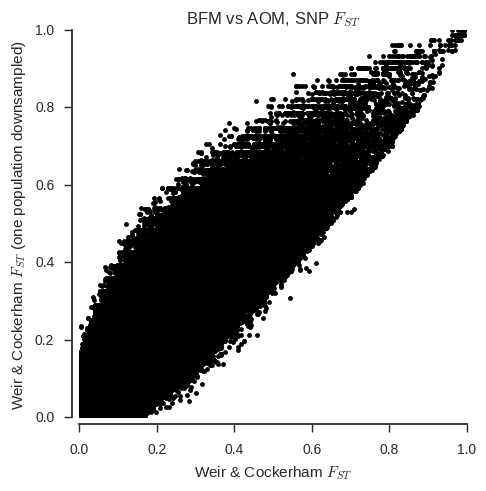

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.despine(ax=ax, offset=5)
ax.plot(snp_fst_wc, snp_fst_wc_ds, color='k', marker='.', linestyle=' ')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Weir & Cockerham $F_{ST}$')
ax.set_ylabel('Weir & Cockerham $F_{ST}$ (one population downsampled)')
ax.set_title('%s vs %s, SNP $F_{ST}$' % (pop1, pop2));

When the sample sizes are unequal, the correspondance between the two estimators is clearly much less. Also, the Weir & Cockerham estimator appears to be systematically different with and without one population down-sampled.

### Chromosome average estimates

Now compute chromosome-wide average F<sub>ST</sub> with standard errors approximated via a block-jackknife.

In [19]:
fst_wc, se_wc, vb_wc, _ = allel.stats.blockwise_weir_cockerham_fst(genotype, subpops=[pop1_idx, pop2_idx], 
                                                                   blen=10000, max_allele=1)
print('%.04f +/- %.04f (Weir & Cockerham)' % (fst_wc, se_wc))

0.1057 +/- 0.0030 (Weir & Cockerham)


In [20]:
fst_hudson, se_hudson, vb_hudson, _ = allel.stats.blockwise_hudson_fst(ac1, ac2, blen=10000)
print('%.04f +/- %.04f (Hudson)' % (fst_hudson, se_hudson))

0.1065 +/- 0.0030 (Hudson)


The two estimates are very close, well within one standard error.

How about with one population downsampled to 20?

In [21]:
fst_wc_ds, se_wc_ds, _, _ = allel.stats.blockwise_weir_cockerham_fst(genotype, subpops=[pop1_idx_ds, pop2_idx], 
                                                                     blen=10000, max_allele=1)
print('%.04f +/- %.04f (Weir & Cockerham)' % (fst_wc_ds, se_wc_ds))

0.1120 +/- 0.0030 (Weir & Cockerham)


In [22]:
fst_hudson_ds, se_hudson_ds, _, _ = allel.stats.blockwise_hudson_fst(ac1_ds, ac2, blen=10000)
print('%.04f +/- %.04f (Hudson)' % (fst_hudson_ds, se_hudson_ds))

0.1057 +/- 0.0030 (Hudson)


The two estimates are now separated by about two standard errors, with the Weir & Cockerham estimator inflated relative to the estimate with full samples from both populations

## SNP ascertainment

Another issue that Bhatia et al. discuss is SNP ascertainment. Basically, how you choose which SNPs to use when estimating F<sub>ST</sub> can make a difference. As I understand it, when computing average F<sub>ST</sub> you want to use a set of SNPs which segregated in the ancestral population, because changes in allele frequency at these SNPs will tell you something about genetic drift. 

Bhatia et al. recommend ascertaining SNPs by choosing SNPs that are segregating in a third "outgroup" population. However, we don't really have an obvious outgroup population in Ag1000G. So we then have four choices: (1) choose SNPs segregating in the first population; (2) choose SNPs segregating in the second population; (3) choose SNPs segregating in either population; (4) choose SNPs segregating in both populations.

Let's explore the impact of different ascertainment schemes, using the Hudson estimator.

In [23]:
def compute_fst(ac1, ac2, scheme):
    
    if scheme == 'first':
        loc_asc = ac1.is_segregating()
    elif scheme == 'second':
        loc_asc = ac2.is_segregating()
    elif scheme == 'either':
        loc_asc = ac1.is_segregating() | ac2.is_segregating()
    elif scheme == 'both':
        loc_asc = ac1.is_segregating() & ac2.is_segregating()    
    n_snps = np.count_nonzero(loc_asc)
    
    ac1 = ac1.compress(loc_asc, axis=0)
    ac2 = ac2.compress(loc_asc, axis=0)
    
    fst, se, _, _ = allel.stats.blockwise_hudson_fst(ac1, ac2, blen=10000)
    
    print('%.04f +/- %.04f (using %s SNPs segregating in %s population)' % (fst, se, n_snps, scheme))

In [24]:
for scheme in 'first', 'second', 'either', 'both':
    compute_fst(ac1, ac2, scheme)

0.1027 +/- 0.0031 (using 2797341 SNPs segregating in first population)
0.1140 +/- 0.0040 (using 1086498 SNPs segregating in second population)
0.1065 +/- 0.0030 (using 3177369 SNPs segregating in either population)
0.1101 +/- 0.0045 (using 706470 SNPs segregating in both population)


The spread of values here is more than three standard errors, so clearly ascertainment makes a difference. Here I'd be inclined to use SNPs segregating in both populations as it is a stricter criterion, however comments very welcome.

## Genome plot

Finally, let's plot F<sub>ST</sub> over the chromosome, to see if any regions are particularly differentiated.

In [25]:
def plot_fst(ac1, ac2, pos, blen=2000):
    
    fst, se, vb, _ = allel.stats.blockwise_hudson_fst(ac1, ac2, blen=blen)
    
    # use the per-block average Fst as the Y coordinate
    y = vb
    
    # use the block centres as the X coordinate
    x = allel.stats.moving_statistic(pos, statistic=lambda v: (v[0] + v[-1]) / 2, size=blen)
    
    # plot
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.despine(ax=ax, offset=5)
    ax.plot(x, y, 'k-', lw=.5)
    ax.set_ylabel('$F_{ST}$')
    ax.set_xlabel('Chromosome %s position (bp)' % chrom)
    ax.set_xlim(0, pos.max())
    

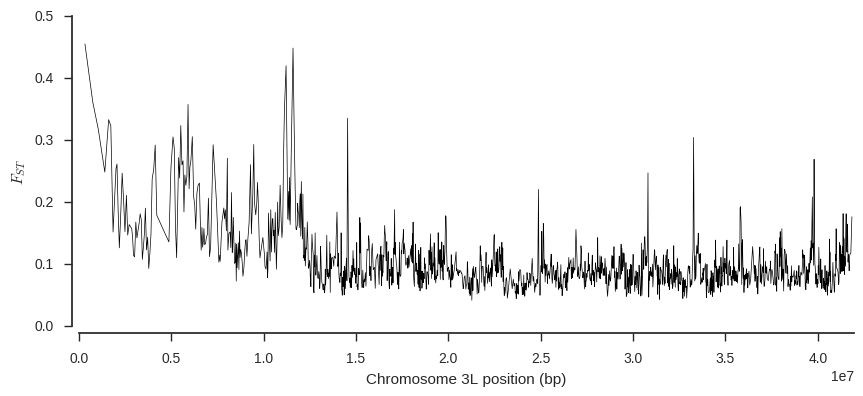

In [26]:
plot_fst(ac1, ac2, pos)

This plot suggests some genome regions where F<sub>ST</sub> is higher than the chromosome-wide average, which are interesting to follow up.

## Conclusions

Hudson's F<sub>ST</sub> estimator is more robust to unequal sample sizes, and faster to compute because it only requires allele counts as input. 

SNP ascertainment also makes a difference. It's probably a good idea to try different ascertainment schemes to see what impact they have on the results. 

## Further reading

* Bhatia, G., Patterson, N., Sankararaman, S., & Price, A. L. (2013). [Estimating and interpreting FST: the impact of rare variants](http://doi.org/10.1101/gr.154831.113). Genome Research, 23(9), 1514–21. 
* [`scikit-allel` F<sub>ST</sub> functions](http://scikit-allel.readthedocs.org/en/latest/stats/fst.html)

<hr/>